In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import matplotlib as mpl

from scipy import optimize, stats

In [2]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2022-el8-x86_64/bin/x86_64-linux/"


COLORS = ["f07167","219ebc","c767ac","E0A100","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load tables

In [3]:
DIR = '/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/'

In [4]:
def combine(X):
    
    return np.concatenate([np.concatenate([X_i[:, 3], X_i[:, 4]]) for X_i in X])

def split_array(arr):
    
    splits = [arr[i:i+50] for i in range(0, len(arr), 50)]  # split the array into 50-point chunks
    
    return splits

def cov_to_corr(cov):
    
    return cov/np.outer(np.sqrt(np.diagonal(cov)), np.sqrt(np.diagonal(cov)))

In [5]:
def DO_FIT(DIR, Force_Rerun = False):
    
    CHAIN_FILE = DIR + '/ABE_Fit_Params.npy'
    
    if os.path.isfile(CHAIN_FILE) & (Force_Rerun == False):
        
        print("FOUND EXISTING CHAIN. LOADING FILE")
        
        X = np.load(CHAIN_FILE, allow_pickle = True)[()]
        
        a_median, b_median, c_median = np.median(X['samples'], axis=0)
        a_err = np.percentile(X['samples'][:, 0], [16, 84]) - a_median
        b_err = np.percentile(X['samples'][:, 1], [16, 84]) - b_median
        c_err = np.percentile(X['samples'][:, 2], [16, 84]) - c_median

        print("----------------------------------")
        print("----------------------------------")
        print(DIR)
        print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
        print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
        print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
        print("----------------------------------")
        print("Best-fit parameters:", X['bf'])
        print("CHI2:", X['bf_chi2'])
        
        return X['bf'], X['samples']
    
    cov = np.loadtxt(DIR + '/taustats_All_cov_treecorr.txt')
    cov = cov[50:, 50:] #Remove shear block

    tau_cov = cov[-150:, -150:]
    inv_tau_cov = np.linalg.inv(tau_cov)
    
    tau0_cov = cov[-150:-100,-150:-100]
    tau1_cov = cov[-100:-50, -100:-50]
    tau2_cov = cov[-50:,-50:]
    
    tau = cov[-150:, -150:]
    
    m_p = np.concatenate([np.arange(25), 50 + np.arange(25), 50*2 + np.arange(25)])
    m_m = np.concatenate([25 + np.arange(25), 25 + 50 + np.arange(25), 25 + 50*2 + np.arange(25)])
    
    tau_p = tau[m_p].T[m_p]
    tau_m = tau[m_m].T[m_m]

    NJK = 150
    hartlap  = (NJK - 75)/(NJK -1)
    dodelson = 1 / (1 + (75 - 3) * (NJK - 75 - 2) / (NJK - 75 - 1) / (NJK - 75 - 4) )
    
    print(hartlap, dodelson, hartlap * dodelson)
    
    
    inv_taup_cov = np.linalg.inv(tau_p) * hartlap * dodelson
    inv_taum_cov = np.linalg.inv(tau_m) * hartlap * dodelson

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]

    combined = combine(datavectors[:])

    mean = combined[50:]

    splits = split_array(mean)

    import emcee

    tau_data = np.concatenate(splits[-3:])

    # Define the log-likelihood function
    def log_likelihood(theta):

        alpha, beta, eta = theta
        
        rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

        tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
        tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
        tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

        diff0 = tau0 - tau0_model
        diff1 = tau1 - tau1_model
        diff2 = tau2 - tau2_model
        
        diff_p = np.concatenate([d[:25] for d in [diff0,diff1,diff2]])
        diff_m = np.concatenate([d[25:] for d in [diff0,diff1,diff2]])

        chi2 = (diff_p @ inv_taup_cov @ diff_p + 
                diff_m @ inv_taum_cov @ diff_m)

        return -chi2

    # Define the log-prior function
    def log_prior(theta):
        # Set uniform priors for a, b, c between -10 and 10
        if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
            return 0.0
        else:
            return -np.inf

    # Define the log-posterior function
    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    # Set up the emcee sampler
    ndim = 3
    nwalkers = 100
    pos = np.random.multivariate_normal([0.001, 1, -1], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

    # Burn in the sampler
    pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

    # Run the sampler for 1000 steps
    sampler.reset()
    sampler.run_mcmc(pos, 2000, progress = True)

    # Get the samples and flatten the chains
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

#     OUT[DIR] = samples

    # Print the median and 1-sigma uncertainties of a, b, c
    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

    print("----------------------------------")
    print("----------------------------------")
    print(DIR)
    print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
    print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
    print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
    print("----------------------------------")

    # Find the index of the maximum log-probability
    max_log_prob_index = np.argmax(sampler.flatlnprobability)
    # Retrieve the corresponding sample
    best_fit_params = sampler.flatchain[max_log_prob_index]

    print("Best-fit parameters:", best_fit_params)

    chi2 = -log_likelihood(best_fit_params)
    print("CHI2:", chi2)
    
    OUT = {'bf' : best_fit_params, 'samples' : samples, "bf_chi2" : chi2}
    
    np.save(CHAIN_FILE, OUT, allow_pickle = True)
    return best_fit_params, samples

In [6]:
best_fit_params, samples = DO_FIT(DIR, Force_Rerun = False)


a_median, b_median, c_median = np.median(samples, axis=0)
a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

0.5033557046979866 0.49990485252140815 0.2516299593228565


100%|██████████| 2000/2000 [00:05<00:00, 353.34it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/
a = -0.0041 +/- 0.0050
b = 1.5812 +/- 0.1170
c = 0.2786 +/- 1.6586
----------------------------------
Best-fit parameters: [-0.00403482  1.57820223  0.24540056]
CHI2: 107.23581552979525


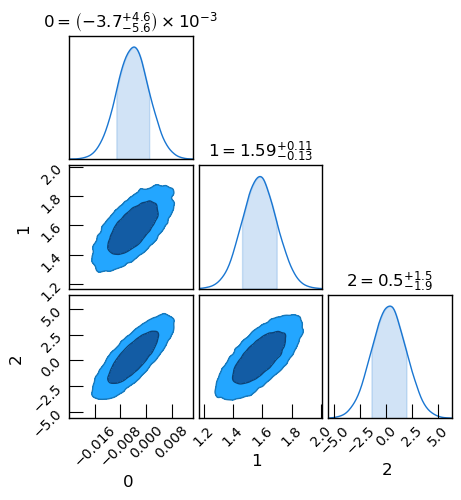

In [7]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(samples)

c.plotter.plot();

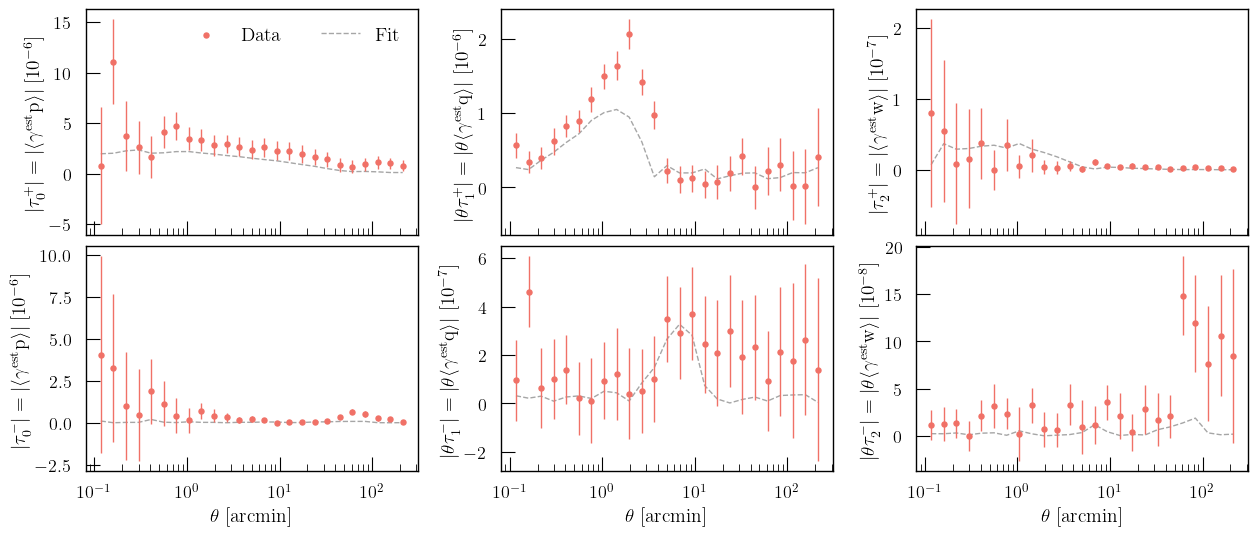

In [14]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)


fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.set_xscale('log') for a in ax.flatten()]
# [a.set_yscale('log') for a in ax.flatten()]

x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 0)

datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
               np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]


cc = [1e-6, 1e-6, 1e-6, 1e-7, 1e-7, 1e-8]
f = x[:, 0]

ax.flatten()[0].scatter(x[:, 0], 1/cc[0]*np.abs(x[:, 3]), s=13, color = COLORS[0], label = 'Data')
ax.flatten()[0].errorbar(x[:, 0], 1/cc[0]*np.abs(x[:, 3]), yerr = 1/cc[0]*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)

ax.flatten()[0 + 3].scatter(x[:, 0], 1/cc[1]*np.abs(x[:, 4]), s=13, color = COLORS[0])
ax.flatten()[0 + 3].errorbar(x[:, 0], 1/cc[1]*np.abs(x[:, 4]), yerr = 1/cc[1]*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)


x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 1)
ax.flatten()[1].scatter(x[:, 0],  1/cc[2]*f*np.abs(x[:, 3]), s=13, color = COLORS[0])
ax.flatten()[1].errorbar(x[:, 0], 1/cc[2]*f*np.abs(x[:, 3]), yerr = 1/cc[2]*f*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1, label = 'Data')

ax.flatten()[1 + 3].scatter(x[:, 0],  1/cc[3]*f*np.abs(x[:, 4]), s=13, color = COLORS[0])
ax.flatten()[1 + 3].errorbar(x[:, 0], 1/cc[3]*f*np.abs(x[:, 4]), yerr = 1/cc[3]*f*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)

x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 2)
ax.flatten()[2].scatter(x[:, 0],  1/cc[4]*np.abs(x[:, 3]), s=13, color = COLORS[0])
ax.flatten()[2].errorbar(x[:, 0], 1/cc[4]*np.abs(x[:, 3]), yerr = 1/cc[4]*x[:, 7], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1, label = 'Data')

ax.flatten()[2 + 3].scatter(x[:, 0],  1/cc[5]*f*np.abs(x[:, 4]), s=13, color = COLORS[0])
ax.flatten()[2 + 3].errorbar(x[:, 0], 1/cc[5]*f*np.abs(x[:, 4]), yerr = 1/cc[5]*f*x[:, 8], fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)

    
ax.flatten()[0].plot(x[:, 0], 1/cc[0]*np.abs(datavectors[1][:, 3] * a_median + 
                                     datavectors[3][:, 3] * b_median + 
                                     datavectors[6][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, label = 'Fit', zorder = -1)

ax.flatten()[3].plot(x[:, 0], 1/cc[1]*np.abs(datavectors[1][:, 4] * a_median + 
                                     datavectors[3][:, 4] * b_median + 
                                     datavectors[6][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)


ax.flatten()[1].plot(x[:, 0], 1/cc[2]*f*np.abs(datavectors[3][:, 3] * a_median + 
                                     datavectors[2][:, 3] * b_median + 
                                     datavectors[5][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)

ax.flatten()[4].plot(x[:, 0], 1/cc[3]*f*np.abs(datavectors[3][:, 4] * a_median + 
                                     datavectors[2][:, 4] * b_median + 
                                     datavectors[5][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)


ax.flatten()[2].plot(x[:, 0], 1/cc[4]*np.abs(datavectors[6][:, 3] * a_median + 
                                     datavectors[5][:, 3] * b_median + 
                                     datavectors[4][:, 3] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)

ax.flatten()[5].plot(x[:, 0], 1/cc[5]*f*np.abs(datavectors[6][:, 4] * a_median + 
                                     datavectors[5][:, 4] * b_median + 
                                     datavectors[4][:, 4] * c_median), color = 'grey', lw = 1, ls='--', alpha = 0.7, zorder = -1)
    
for i, l in enumerate([r'$|\tau_0^+| = |\langle \rm \gamma^{\rm est} p\rangle|$  [$10^{-6}$]',
                       r'$|\theta\tau_1^+| = |\theta\langle \rm \gamma^{\rm est} q\rangle|$  [$10^{-6}$]',
                       r'$|\tau_2^+| = |\langle \rm \gamma^{\rm est} w\rangle|$  [$10^{-7}$]',
                       r'$|\tau_0^-| = |\langle \rm \gamma^{\rm est} p\rangle|$  [$10^{-6}$]',
                       r'$|\theta\tau_1^-| = |\theta\langle \rm \gamma^{\rm est} q\rangle|$  [$10^{-7}$]',
                       r'$|\theta\tau_2^-| = |\theta\langle \rm \gamma^{\rm est} w\rangle|$  [$10^{-8}$]']):
    ax.flatten()[i].set_ylabel(r'%s' % l, size = 14, labelpad = 3)
    
ax.flat[0].legend(fontsize = 14, frameon = False, ncol = 2)
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 14) for i in [3, 4, 5]];

[a.tick_params(pad = 10) for a in ax.flat]
plt.savefig('./Tau_Stats.pdf', bbox_inches = 'tight', dpi = 400)

FOUND EXISTING CHAIN. LOADING FILE
----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/
a = -0.0041 +/- 0.0050
b = 1.5812 +/- 0.1170
c = 0.2786 +/- 1.6586
----------------------------------
Best-fit parameters: [-0.00403482  1.57820223  0.24540056]
CHI2: 107.23581552979525


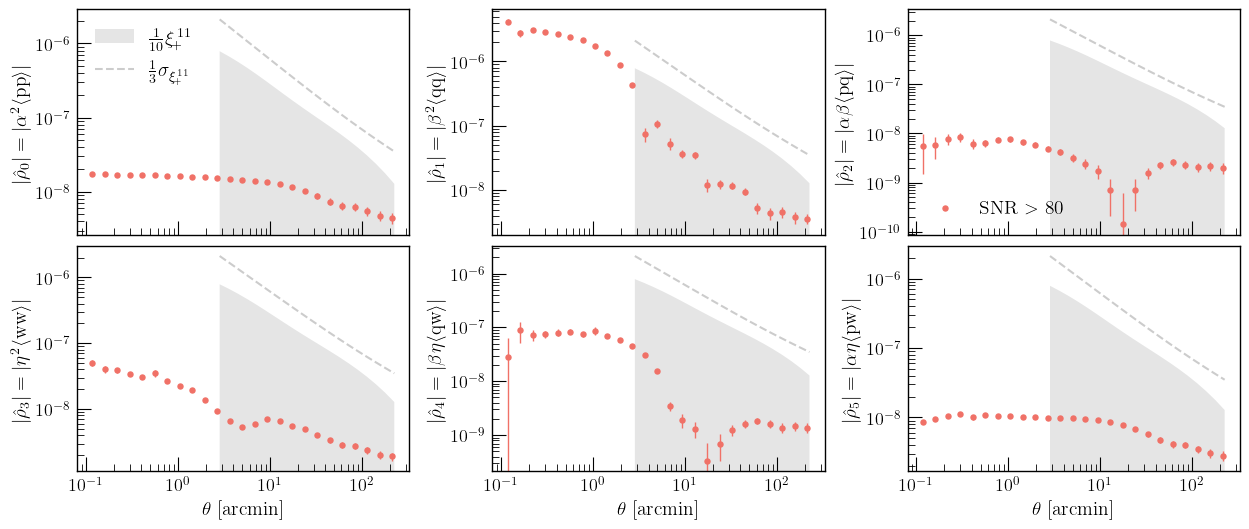

In [13]:
from astropy.io import fits

plt.rc('font', family='serif', size=13)

fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]
    

xi_plus_11 = fits.open('/home/dhayaa/DECADE/CosmicShearCosmosis/datavectors/baseline_20240901.fits')[2].data[:20]
for i in range(6):
    ax.flatten()[i].fill_between(xi_plus_11['ANG'], np.zeros(20), 0.1*xi_plus_11['VALUE'], color = 'k', alpha = 0.1, 
                                 label = r'$\frac{1}{10}\xi_{\!+}^{\,11}$' if i == 0 else None, lw = 0)
    
xi_cov = fits.open('/home/dhayaa/DECADE/CosmicShearCosmosis/datavectors/baseline_20240901.fits')['COVMAT'].data
xi_plus_11_sigma = np.sqrt(np.diag(xi_cov))[:20]
for i in range(6):
    ax.flatten()[i].plot(xi_plus_11['ANG'], 1/3*xi_plus_11_sigma, color = 'k', alpha = 0.2, ls = '--', 
                         label = r'$\frac{1}{3}\sigma_{\xi_{\!+}^{\,11}}$' if i == 0 else None)

    
best_fit_params, samples = DO_FIT('/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/', Force_Rerun = False)

a, b, e = best_fit_params
a = np.percentile(samples[:, 0], 99)
b = np.percentile(samples[:, 1], 84)
e = np.percentile(samples[:, 2], 84)
coeffs = [a*a, b*b, a*b, e*e, b*e, a*e]

for i in range(6):

    x = np.loadtxt('/scratch/midway3/dhayaa/SHEARTESTS_20241219/FIDUCIAL/' + '/taustats_rho%d_treecorr.txt' % i)
    ax.flatten()[i].scatter(x[:, 0], np.abs(coeffs[i]) * np.abs(x[:, 3]), s=13, 
                            label = 'SNR $>$ 80' if i == 2 else None, color = COLORS[0])

    ax.flatten()[i].errorbar(x[:, 0], np.abs(coeffs[i]) * np.abs(x[:, 3]), yerr = np.abs(coeffs[i]) * x[:, 7], 
                             fmt = 'none', color = COLORS[0], lw = 0, elinewidth = 1)
     

ax.flat[0].legend(fontsize = 14, frameon = False)
ax.flat[2].legend(fontsize = 14, frameon = False)

for i, l in enumerate([r'$|\hat{\rho}_0| = |\alpha^2\langle {\rm pp} \rangle|$',
                       r'$|\hat{\rho}_1| = |\beta^2\langle {\rm qq} \rangle|$',
                       r'$|\hat{\rho}_2| = |\alpha\beta\langle {\rm pq} \rangle|$',
                       r'$|\hat{\rho}_3| = |\eta^2\langle {\rm ww} \rangle|$',
                       r'$|\hat{\rho}_4| = |\beta\eta\langle {\rm qw} \rangle|$',
                       r'$|\hat{\rho}_5| = |\alpha\eta\langle {\rm pw} \rangle|$']):
    ax.flatten()[i].set_ylabel(r'%s' % l, size = 14)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 14) for i in [3, 4, 5]];

[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 14) for i in [3, 4, 5]];

[a.tick_params(pad = 5) for a in ax.flat]

plt.savefig('./Rowe_stats.pdf', bbox_inches = 'tight', dpi = 400)